## Load Dataset

In [29]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
import time


#train and test data directory
data_dir = "../../../02_data_crop/train"
test_data_dir = "../../../02_data_crop/train"


#load the train and test data as Tensors
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((64,64)),transforms.ToTensor()
]))

In [30]:
img, label = dataset[0]
print('Image Shape: ', img.shape,label)  # Channel, height, width

Image Shape:  torch.Size([3, 64, 64]) 0


In [31]:
# automatische Zuordnung von Bilder und Labels
print("Follwing classes are there : \n",dataset.classes)  # nicht natsorted, sollte aber unwichtig sein

Follwing classes are there : 
 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '3', '4', '5', '6', '7', '8', '9']


Label : 1


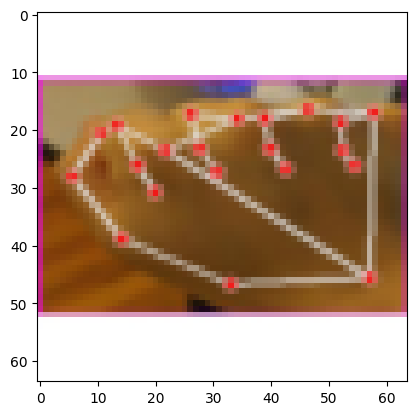

In [32]:
# Dataset ist nicht geshuffelt
import matplotlib.pyplot as plt
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

Validierungsdaten sind aus Trainingsdaten gewonnen

In [33]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")


#load the train and validation into batches and shuffle
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 8368
Length of Validation Data : 2000


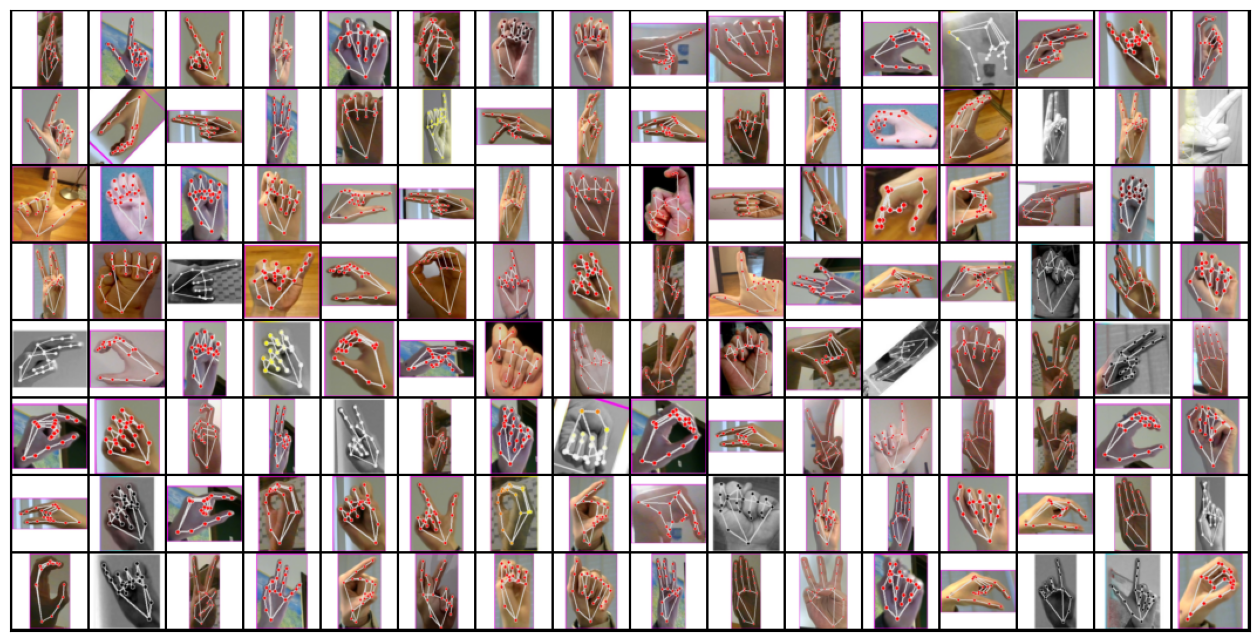

In [34]:
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

## Create Model

Define loss and accuracy + output

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        train_loss = F.cross_entropy(out, labels) # Calculate loss
        train_acc = accuracy(out, labels)
        return train_loss, train_acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

Define model parameters

In [54]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(16384,1024),  # letzter Wert = erster Wert der nächsten Schicht
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,26)  # Anzahl classes
        )
    
    def forward(self, xb):
        return self.network(xb)

In [55]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# training function  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss, _ = model.training_step(batch)
            _, acc = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = acc
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [56]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
model = NaturalSceneClassification()
#fitting the model on training data and record the result after each epoch
print("[INFO] training the network...")
startTime = time.time()

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}min".format((endTime - startTime)/ 60))

[INFO] training the network...
Epoch [0], train_loss: 2.9392, train_acc: 0.1667, val_loss: 2.5232, val_acc: 0.1910
Epoch [1], train_loss: 2.2294, train_acc: 0.3958, val_loss: 1.8524, val_acc: 0.3873
Epoch [2], train_loss: 1.2929, train_acc: 0.7917, val_loss: 0.9640, val_acc: 0.6948
Epoch [3], train_loss: 0.6796, train_acc: 0.7708, val_loss: 0.5762, val_acc: 0.8320
Epoch [4], train_loss: 0.4113, train_acc: 0.8750, val_loss: 0.5327, val_acc: 0.8514
Epoch [5], train_loss: 0.2657, train_acc: 0.9167, val_loss: 0.3682, val_acc: 0.8973
Epoch [6], train_loss: 0.1968, train_acc: 0.9792, val_loss: 0.3658, val_acc: 0.9061
Epoch [7], train_loss: 0.1300, train_acc: 0.9583, val_loss: 0.4054, val_acc: 0.9087
Epoch [8], train_loss: 0.0929, train_acc: 0.9583, val_loss: 0.3382, val_acc: 0.9186
Epoch [9], train_loss: 0.0817, train_acc: 1.0000, val_loss: 0.3382, val_acc: 0.9315
Epoch [10], train_loss: 0.0363, train_acc: 0.9792, val_loss: 0.4517, val_acc: 0.9067
Epoch [11], train_loss: 0.0679, train_acc: 0

In [57]:
torch.save(model, ('output/model.pth'))

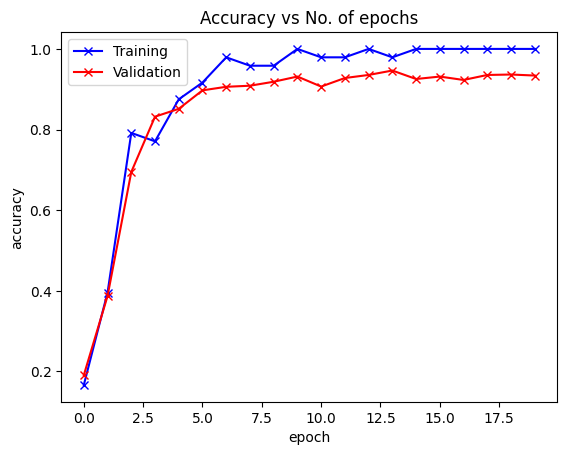

In [58]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    val_acc = [x['val_acc'] for x in history]
    train_acc = [x['train_acc'] for x in history]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs No. of epochs');
    

plot_accuracies(history)

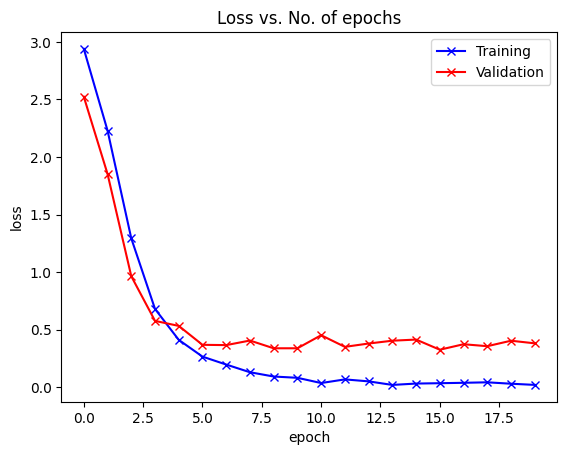

In [59]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

## Testing

In [60]:
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")

batch_size = 128
test_dl = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)
# set the model in evaluation mode
model.eval

preds = []
targets = []

# loop over the test loader


for image, label in test_dl:
		pred = model(image)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
		targets.extend(label.cpu().numpy())  # Annahme: Die Labels sind im zweiten Element des Batches

# generate a classification report
print(classification_report(targets, np.array(preds), target_names=test_dataset.classes))
#print(classification_report(test_dataset.targets.cpu().numpy(),np.array(preds), target_names=test_dataset.classes))

[INFO] evaluating network...
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       494
          10       0.99      0.98      0.98       321
          11       1.00      0.99      0.99       426
          12       0.99      1.00      0.99       430
          13       0.98      0.97      0.98       398
          14       0.99      0.98      0.98       428
          15       0.99      0.98      0.99       417
          16       0.92      0.99      0.96       396
          17       0.99      0.99      0.99       386
          18       0.95      0.99      0.97       398
          19       0.99      0.99      0.99       408
           2       0.99      0.98      0.98       444
          20       1.00      0.99      1.00       409
          21       0.95      0.99      0.97       407
          22       0.98      0.92      0.95       425
          23       0.98      0.99      0.98       402
          24       0.99      0.99      0.99       38

precision: Anzahl der korrekten Vorhersagen
recall: 

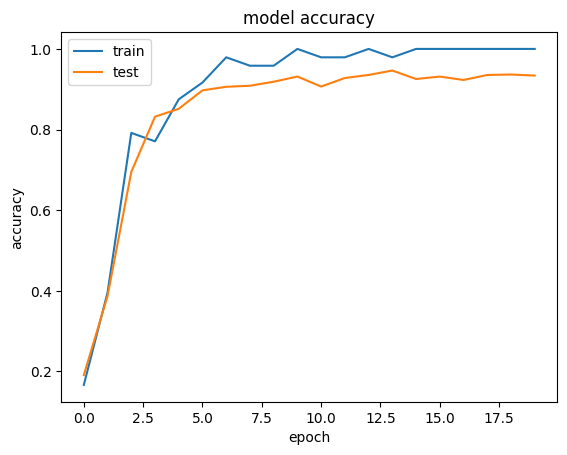

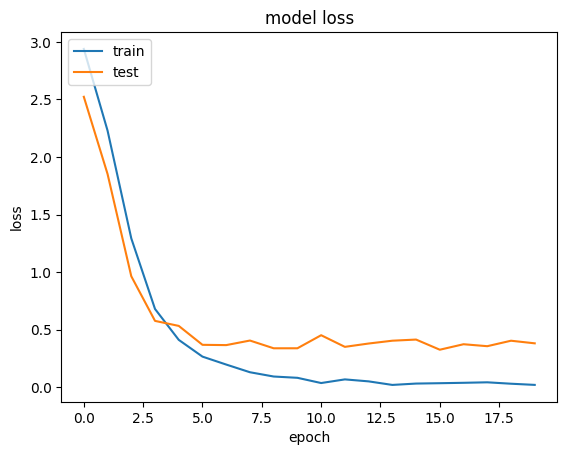

In [61]:
# summarize history for accuracy

train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
train_acc = [x['train_acc'] for x in history]
val_acc = [x['val_acc'] for x in history]

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

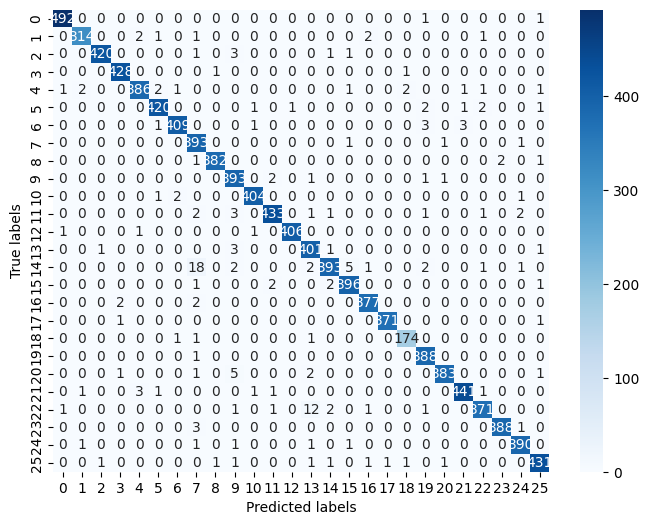

In [63]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

def get_all_predictions(model, data_loader):
    all_preds = []
    all_labels = []
    for batch in data_loader:
        images, labels = batch
        preds = model(images)
        _, pred_labels = torch.max(preds, dim=1)
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

def plot_confusion_matrix(model, data_loader):
    all_preds, all_labels = get_all_predictions(model, data_loader)
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for test data')
    plt.show()

# Verwende die Funktion plot_confusion_matrix nach dem Training deines Modells mit den Testdaten
plot_confusion_matrix(model, test_dl)

Predict single images

In [3]:
import cv2
import numpy as np
import torch

from torch.utils.data import Subset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Laden des trainierten Modells
model = torch.load("output/model.pth").to(device)

idxs = np.random.choice(range(0, len(test_dataset)), size=(3,))
testData = Subset(test_dataset, idxs)


# Iteration über die zufällig ausgewählten Bilder
for image in testData:
    img = image[0]
    gtLabel = image[1]

    # Vorhersage des Labels für das Bild
    predLabel = model.predict_classes(np.array([img]))

    # Anzeige des Bildes mit dem vorhergesagten Label
    origImage = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
    cv2.putText(origImage, str(gtLabel), (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

    # Anzeige der Ergebnisse im Terminal und des Bildes
    print("[INFO] ground truth label: {}, predicted label: {}".format(gtLabel, predLabel))
    cv2.imshow("image", origImage)
    cv2.waitKey(0)

AttributeError: Can't get attribute 'NaturalSceneClassification' on <module '__main__'>

In [68]:
from torch.utils.data import Subset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

idxs = np.random.choice(range(0, len(test_dataset)), size=(3,))
testData = Subset(test_dataset, idxs)

# initialize the test data loader
#testDataLoader = DataLoader(testData, batch_size=1)

# load the model and set it to evaluation mode
model = torch.load("output/model.pth").to(device)
model.eval()

# switch off autograd
with torch.no_grad():
	# loop over the test set
	for (image, label) in testData:#testDataLoader:
		# grab the original image and ground truth label
		origImage = image.numpy() #.squeeze(axis=(0, 1))
		gtLabel = testData.dataset.classes[label]
		# send the input to the device and make predictions on it
		image = image.to(device)
		pred = model(image)
		# find the class label index with the largest corresponding
		# probability
		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = testData.dataset.classes[idx]
		

		# draw the predicted class label on it
		color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
		cv2.putText(origImage, gtLabel, (2, 25),
			cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
		# display the result in terminal and show the input image
		print("[INFO] ground truth label: {}, predicted label: {}".format(
			gtLabel, predLabel))
		cv2.imshow("image", origImage)
		cv2.waitKey(0)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x64 and 16384x1024)

: 